#Necessary Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import glob
import math
import os
from moviepy.editor import VideoFileClip

#Reading The Image

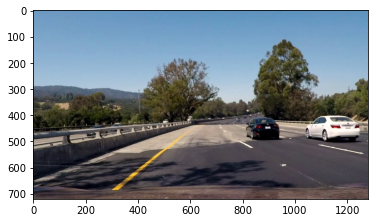

In [2]:
image = cv2.imread("test1.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [3]:
height = image.shape[0]
print(height)
width = image.shape[1]
print(width)

720
1280


#Functions

In [4]:
def show_image(image, title="title", cmap_type="gray"):
    plt.imshow(image, cmap_type)
    plt.title(title)

In [5]:
# applying gaussian blur
def gaussian_blur(image,height,width):
    return cv2.GaussianBlur(image,(height, width),0)

In [6]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [7]:
region_of_interest_vertices = [
    (0, height),
    (width / 2,400),
    (width, height),
]

#Using Grayscale, Gaussian Blur, Cropping the image and using binary threshold

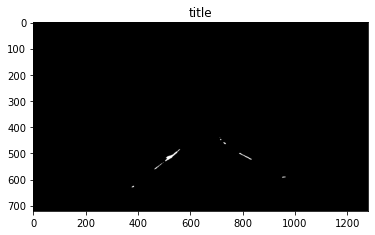

In [8]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cannyed_image = cv2.Canny(gray,100,200, L2gradient = True)
blurred = gaussian_blur(gray,7,7)
cropped_image = region_of_interest(
    blurred,
    np.array([region_of_interest_vertices], np.int32)
)

(T, threshInv) = cv2.threshold(cropped_image, 200, 255,cv2.THRESH_BINARY)
#cv2.imshow("Threshold Binary Inverse", threshInv)
show_image(threshInv)

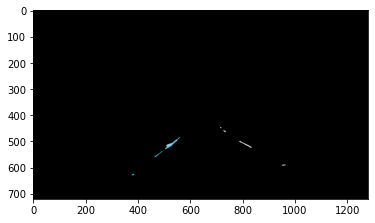

In [9]:
masked = cv2.bitwise_and(image, image, mask=threshInv)
plt.imshow(masked)

#show_image(masked)

#Sobel Transform and binary Image

In [10]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

gray = hls[:, :, 1]

s_channel = hls[:, :, 2]

In [11]:
sobel_kernel=7
mag_thresh=(3, 255)
s_thresh=(170, 255)
th=(10,100)

In [12]:
sobel_binary = np.zeros(shape=gray.shape, dtype=bool)
s_binary = sobel_binary
combined_binary = s_binary.astype(np.float32)

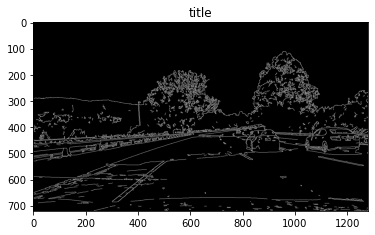

In [13]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7)
sobely = 0
#sobelxy = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7)
show_image(sobelx)
edges = cv2.Canny(gray, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Canny Edge Detection Image
show_image(edges)

In [14]:
sobel_abs = np.abs(sobelx**2 + sobely**2)
sobel_abs = np.uint8(255 * sobel_abs / np.max(sobel_abs))

In [15]:
sobel_binary[(sobel_abs > mag_thresh[0]) & (sobel_abs <= mag_thresh[1])] = 1

# Threshold color channel
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

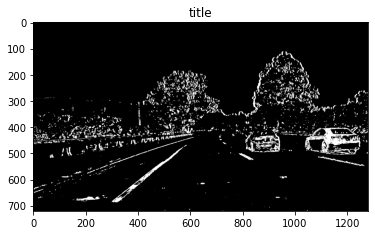

In [16]:
combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
combined_binary = np.uint8(255 * combined_binary / np.max(combined_binary))
show_image(combined_binary)

In [17]:
def masked_image(combined_binary):
    offset = 100
    mask_poly =np.array([[(0 + offset, image.shape[0]),
                            (image.shape[1] / 2.3, image.shape[0] / 1.65),
                            (image.shape[1] / 1.7, image.shape[0] / 1.65),
                            (image.shape[1], image.shape[0])]],
                          dtype=int)
    mask_img = np.zeros_like(combined_binary)
    ignore_mask_color = 255
    cv2.fillPoly(mask_img, mask_poly, ignore_mask_color)
    masked_edges = cv2.bitwise_and(combined_binary, mask_img)
    return masked_edges

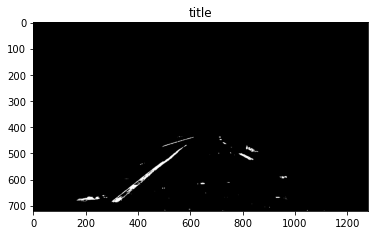

In [18]:
show_image(masked_image(combined_binary))

#Src and dst Points

In [19]:
src = [595, 452], \
          [685, 452], \
          [1110, image.shape[0]], \
          [220, image.shape[0]]
line_dst_offset = 100
dst = [src[3][0] + line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, src[2][1]], \
          [src[3][0] + line_dst_offset, src[3][1]]

#Perspective Transform Function

In [20]:
def warp(image, src, dst):

    src = np.float32([src])
    dst = np.float32([dst])
    
    return cv2.warpPerspective(image, cv2.getPerspectiveTransform(src, dst),
                               dsize=image.shape[0:2][::-1], flags=cv2.INTER_LINEAR)

#Using Sobel and Binary Image 

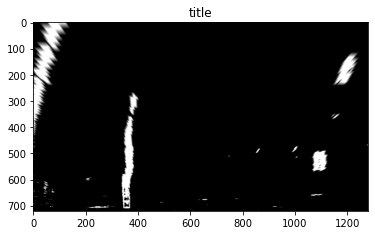

In [21]:
Perspective_img1=(warp(combined_binary,src,dst))
show_image(Perspective_img1)

#Using Gaussian Blur and Binary Thresholding 

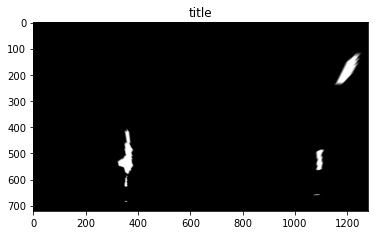

In [22]:
Perspective_img=(warp(threshInv,src,dst))
show_image(Perspective_img)

#Inverse Perspective Transform

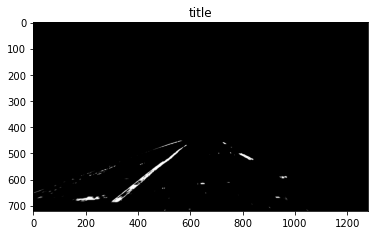

In [23]:
show_image(warp(Perspective_img1,dst,src))

In [24]:
def get_warped_image_histogram(image):
    return np.sum(image[image.shape[0] // 2:, :], axis=0)

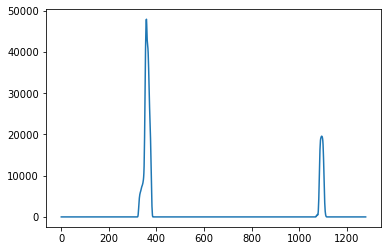

In [25]:
histogram = get_warped_image_histogram(Perspective_img)
plt.plot(histogram)
plt.show()

In [26]:
def sliding_window(image, n_windows=9):
    # Get Binary image histogram
    histogram = get_warped_image_histogram(image)
    
    # Allow image to be RGB to display sliding windows.
    out = np.dstack((image, image, image)) * 255
    
    # Get Center of left and right peaks.
    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Calculate window height.
    window_height = image.shape[0] // n_windows
    
    # Get indicies that map to non zero values.
    non_zero_y, non_zero_x = map(lambda x: np.array(x), image.nonzero())
    
    margin = 50 # Width of sliding window.
    min_pixels = 50 # Min amount of pixels that match inside the window to detect a lane.
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_indicies = []
    right_lane_indicies = []
    
    for window in range(n_windows):
        # Calculate window vertices positions.
        win_y_low = image.shape[0] - (window + 1) * window_height # Y coordinate of top corners. 
        win_y_high = image.shape[0] - window * window_height # Y coordinate of bottom corners.
        win_xleft_low = leftx_current - margin # X coordinate of left side of the window at the left side of the lane.
        win_xleft_high = leftx_current + margin # X coordinate of right side of the window at the left side of the lane.
        win_xright_low = rightx_current - margin # X coordinate of left side of the window at the right side of the lane.
        win_xright_high = rightx_current + margin # X coordinate of right side of the window at the right side of the lane.
        
        # Draw green rectangle at current windows.
        cv2.rectangle(out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        good_left_indicies = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xleft_low) & (
            non_zero_x < win_xleft_high)).nonzero()[0] # Check if index is inside the left window.
        good_right_indicies = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xright_low) & (
            non_zero_x < win_xright_high)).nonzero()[0] # Check if index is inside the right window.
        
        left_lane_indicies.append(good_left_indicies)
        right_lane_indicies.append(good_right_indicies)
        
        # Shift left to the mean.
        if len(good_left_indicies) > min_pixels:
            leftx_current = int(np.mean(non_zero_x[good_left_indicies]))
        if len(good_right_indicies) > min_pixels:
            rightx_current = int(np.mean(non_zero_x[good_right_indicies]))
    
    left_lane_indicies = np.concatenate(left_lane_indicies)
    right_lane_indicies = np.concatenate(right_lane_indicies)

    # Pixels that matched in the left side of the lane.
    left_x = non_zero_x[left_lane_indicies]
    left_y = non_zero_y[left_lane_indicies]
    
    # Pixels that matched in the right side of the lane.
    right_x = non_zero_x[right_lane_indicies]
    right_y = non_zero_y[right_lane_indicies]

    # Fit the points using a second degree polynomial.
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
        
    return out, left_fit, right_fit

In [27]:
def draw_lines_and_fill(image, warped_image, left_fit, right_fit, src, dest):
    
    # Make a zero like copy of warped image.
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    
    # Make rgb image of zeros.
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Create a y axis.
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
        
    # Left line polynomial.
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    # Right Line polynomial.
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(color_warp_center, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, dest, src)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.2, 0)

    color_warp_lines = np.dstack((warp_zero, warp_zero, warp_zero))
    cv2.polylines(color_warp_lines, np.int_([pts_left]), isClosed=False, color=(0, 0, 255), thickness=25)
    cv2.polylines(color_warp_lines, np.int_([pts_right]), isClosed=False, color=(0, 0, 255), thickness=25)
    newwarp_lines = warp(color_warp_lines, dest, src)

    result = cv2.addWeighted(result, 1, newwarp_lines, 1, 0)

    return result

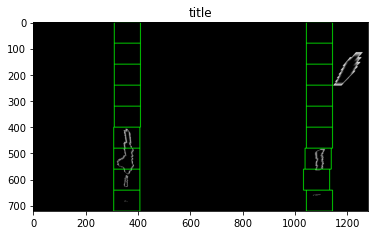

In [28]:
image_with_sliding_window, left_fit, right_fit = sliding_window(Perspective_img)
show_image(image_with_sliding_window)

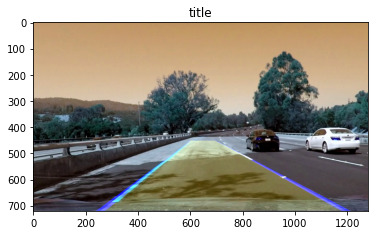

In [29]:
final_image = draw_lines_and_fill(image, Perspective_img, left_fit, right_fit, src, dst)
show_image(final_image)

#Calculating Vehicle Position and Curve Radius

In [30]:
def measure_curvature_meters(Perspective_img, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def measure_position_meters(Perspective_img, left_fit, right_fit):
    # Define conversion in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Choose the y value corresponding to the bottom of the image
    y_max = Perspective_img.shape[0]
    # Calculate left and right line positions at the bottom of the image
    left_x_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    # Calculate the x position of the center of the lane 
    center_lanes_x_pos = (left_x_pos + right_x_pos)//2
    # Calculate the deviation between the center of the lane and the center of the picture
    # The car is assumed to be placed in the center of the picture
    # If the deviation is negative, the car is on the felt hand side of the center of the lane
    veh_pos = ((Perspective_img.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
    return veh_pos

In [31]:
# Create a y axis.
ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
# Left line polynomial.
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
# Right Line polynomial.
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]


left_curverad, right_curverad =  measure_curvature_meters(Perspective_img, left_fitx, right_fitx, ploty)
print('left curve radius in meters  = ', left_curverad)
print('right curve radius in meters = ', right_curverad)
veh_pos = measure_position_meters(Perspective_img, left_fit, right_fit)
print('vehicle position relative to center  = ', veh_pos)

left curve radius in meters  =  2975.851979809101
right curve radius in meters =  1550.5247313358018
vehicle position relative to center  =  -0.3858571428571429


#Adding Lane info to Image

In [32]:
def project_lane_info(image, Perspective_img, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(Perspective_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    out_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    cv2.putText(out_img,'Curve Radius [m]: '+str((left_curverad+right_curverad)/2)[:7],(40,70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,'Center Offset [m]: '+str(veh_pos)[:7],(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)
    
    return out_img

Text(0.5, 1.0, 'Image With Lane Marked')

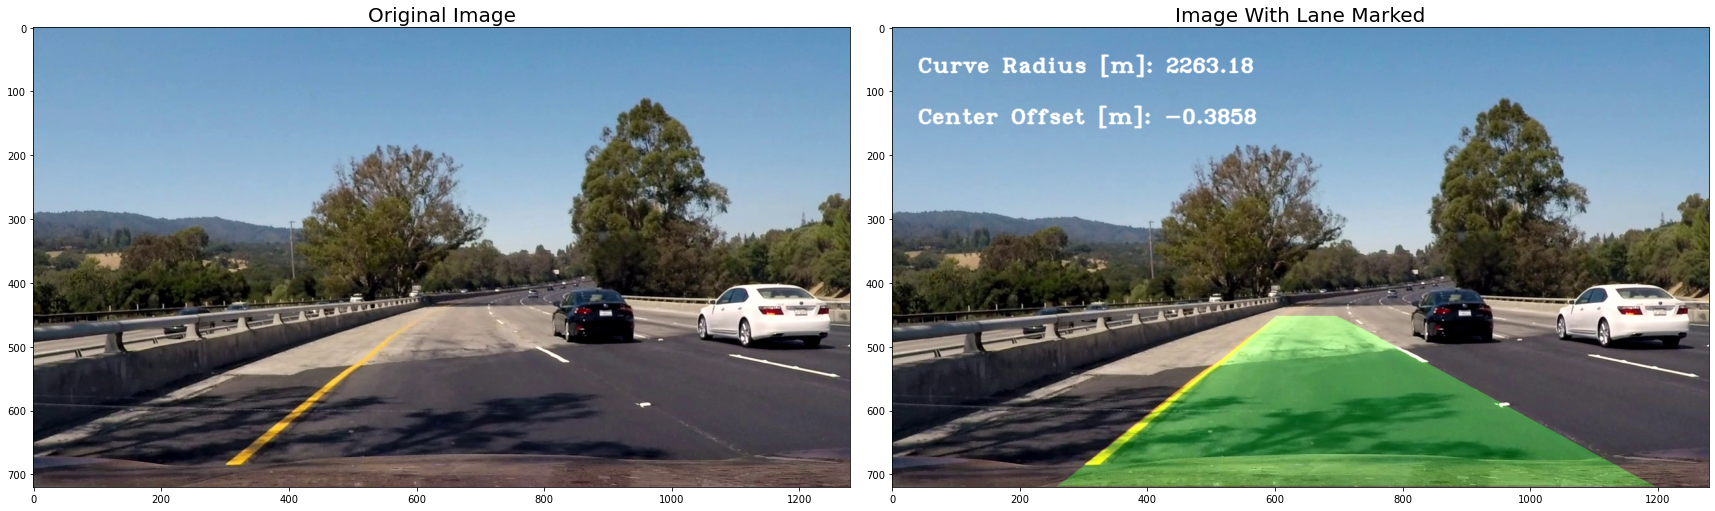

In [33]:
src = np.float32([src])
dst = np.float32([dst])
M_inv = cv2.getPerspectiveTransform(dst, src)
new_img = project_lane_info(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), Perspective_img, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(new_img, cmap='gray')
ax2.set_title('Image With Lane Marked', fontsize=20)

#Reading The Video Frame by Frame

#Making a list of video frames